Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [19]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import platform
import sys
import scipy as sp 
import sklearn as sk

from tensorflow import keras

from keras import layers

from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten 
from tensorflow.keras.layers import Conv2D 
from tensorflow.keras.layers import MaxPooling2D

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau
#from tensorflow.keras.utils.np_utils import to_categorical

from tensorflow.keras.layers import Rescaling
#from tensorflow.python.keras. import ImageDataGenerator




In [20]:
print (f"Python Platform: {platform.platform ()}")
print (f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {keras.__version__}")
print ()

print (f"Python {sys.version}")
print (f"Pandas {pd.__version__}")
print (f"Scikit-Learn {sk.__version__}")
print (f"SciPy {sp.__version__}")

devices = tf.config.list_physical_devices()
print("\nDevices: ", devices)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  details = tf.config.experimental.get_device_details(gpus[0])
  print("GPU details: ", details)

Python Platform: macOS-10.16-x86_64-i386-64bit
Tensor Flow Version: 2.12.0
Keras Version: 2.12.0

Python 3.11.5 (main, Sep 11 2023, 08:40:08) [Clang 14.0.6 ]
Pandas 2.2.1
Scikit-Learn 1.2.2
SciPy 1.11.4

Devices:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [ ]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [21]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("./cancerData/Train")
data_dir_test = pathlib.Path('./cancerData/Test/')

In [22]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [23]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [24]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [25]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [26]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [27]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

2024-05-07 12:53:24.597211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1792]
	 [[{{node Placeholder/_0}}]]
2024-05-07 12:53:24.597618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1792]
	 [[{{node Placeholder/_4}}]]


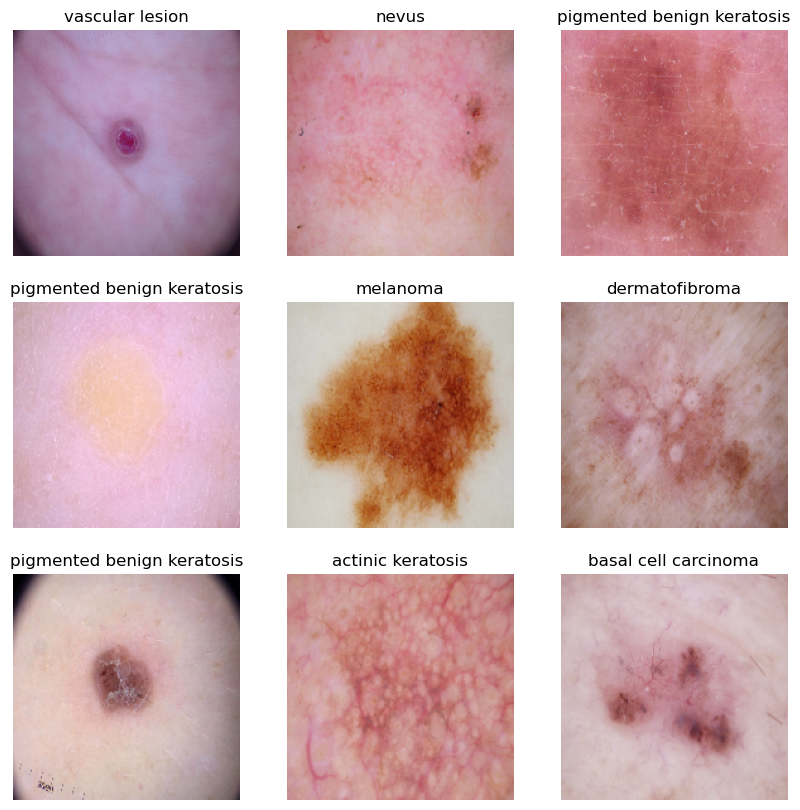

In [28]:


def plot_visuals(figsize_X, figsize_Y, subplot_X, subPlot_Y):
  plt.figure(figsize=(figsize_X, figsize_Y))
  for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(subplot_X, subPlot_Y, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
### your code goes here, you can use training or validation data to visualize

plot_visuals(10,10,3,3)

#### 

* Please note down that the above warning perhaps may skip the model epochs as noted in https://github.com/tensorflow/tensorflow/issues/62963


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [29]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [30]:
preprocessing_layers = [
    Rescaling(1./255, input_shape=(180, 180, 3))
]

In [31]:
### Your code goes here

#def preprocessing_layers(rescaleVal, ishape_X, ishape_Y, ilayerRGB):
#    return rescaling(rescaleVal, input_shape=(ishape_X, ishape_Y, ilayerRGB))

#preproc_layers = preprocessing_layers(1./255, 180, 180, 3)

def create_model():
    input_shape = (180,180,3)
    lr = 1e-5
    init = 'normal'
    activ = 'relu'

    model = Sequential([
    layers.Rescaling(1./255,input_shape=input_shape),
    
    Conv2D(32, (3, 3), activation='relu', padding='same',input_shape=input_shape),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding='same',input_shape=input_shape),
    MaxPooling2D((2, 2)),


    Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    MaxPooling2D((2, 2)),


    Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax')
])
    
    return model,model.summary()


model,model_summary = create_model()

#print(model_summary)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 45, 45, 128)      

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [32]:
### Todo, choose an appropirate optimiser and loss function

def control_lr_rate():
    learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
    return learn_control
def compile_model(model, optimizer, lossType, metrics):
    model.compile(optimizer=optimizer,
              loss=lossType,
              metrics=metrics)
compile_model(model, 'adam', "sparse_categorical_crossentropy", ['accuracy'])

In [33]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 45, 45, 128)      

### Train the model

In [34]:
def train_model(model,epochs, train_data, valid_data, callbacks):
  history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=callbacks
)
  return history
history = train_model(model, 20, train_ds, val_ds, control_lr_rate())

Epoch 1/20


2024-05-07 12:53:49.494734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1792]
	 [[{{node Placeholder/_0}}]]
2024-05-07 12:53:49.495266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1792]
	 [[{{node Placeholder/_0}}]]


56/56 [==============================] - ETA: 0s - loss: 2.0694 - accuracy: 0.1981

2024-05-07 12:54:16.460131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [447]
	 [[{{node Placeholder/_4}}]]
2024-05-07 12:54:16.460461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [447]
	 [[{{node Placeholder/_4}}]]


56/56 [==============================] - 30s 449ms/step - loss: 2.0694 - accuracy: 0.1981 - val_loss: 2.0265 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 25s 440ms/step - loss: 1.9533 - accuracy: 0.2757 - val_loss: 1.7860 - val_accuracy: 0.3177 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 25s 440ms/step - loss: 1.8464 - accuracy: 0.3326 - val_loss: 1.9095 - val_accuracy: 0.2975 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 25s 441ms/step - loss: 1.7173 - accuracy: 0.3644 - val_loss: 1.6968 - val_accuracy: 0.3490 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 24s 436ms/step - loss: 1.5864 - accuracy: 0.4213 - val_loss: 1.5057 - val_accuracy: 0.4743 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 25s 440ms/step - loss: 1.5230 - accuracy: 0.4593 - val_loss: 1.4280 - val_accuracy: 0.5213 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - 25s 439ms/step - loss: 

### Visualizing training results

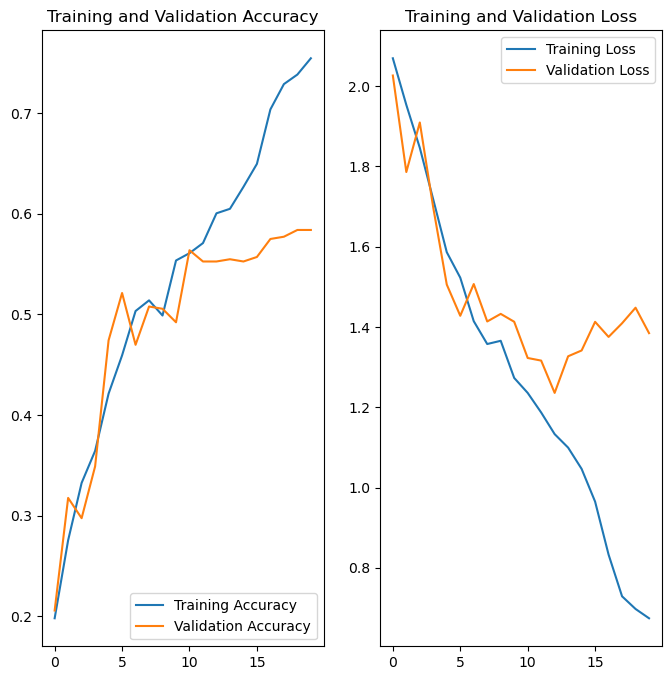

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [36]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here

loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 2s 121ms/step - loss: 1.3848 - accuracy: 0.5839
Accuracy:  0.78515625
Validation Accuracy:  0.5838926434516907
Loss:  0.5722914934158325
Validation Loss 1.3847885131835938


#### Observations

* The training accuracy is 0.2075, Validation accuracy is 0.2035
* The training loss is 2.01221, Validation loss is 2.0233
* Both are values are quite low.
* Seemingly low training accuracy and lesser validation accuracy implies underfitting.
* Training and Validation losses are nearly same but compared to the former, latter has less spikes ie less fluctuating.

#### MODEL NOT GOOD

In [37]:
def image_dat_gen():
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images in horizontal direction
        vertical_flip=False) # randomly flip images in vertical direction
    return datagen


datagen = image_dat_gen()

image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

train_batches = datagen.flow_from_directory(data_dir_train, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(data_dir_test, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)

Found 890 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


2024-05-07 13:08:39.443958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1792]
	 [[{{node Placeholder/_4}}]]
2024-05-07 13:08:39.444563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [1792]
	 [[{{node Placeholder/_4}}]]


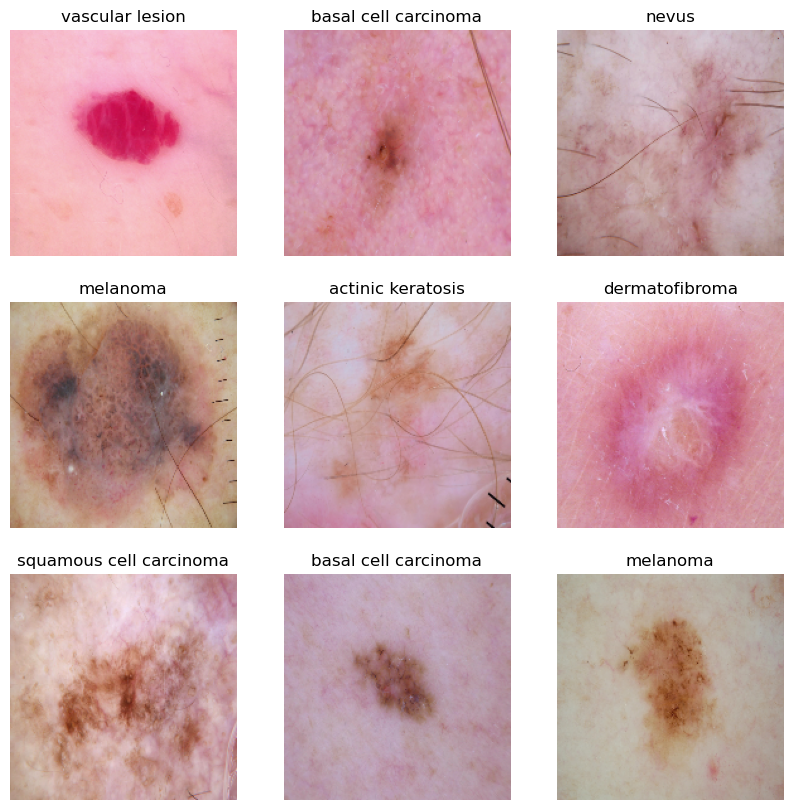

In [38]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [39]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model, model.summary = create_model()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 45, 45, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 45, 45, 128)      

### Compiling the model

In [40]:
## Your code goes here

compile_model(model,'adam',"sparse_categorical_crossentropy",['accuracy'])

### Training the model

In [41]:
## Your code goes here, note: train your model for 20 epochs
history = train_model(model, 20, train_ds, val_ds, control_lr_rate())

Epoch 1/20
56/56 [==============================] - 26s 444ms/step - loss: 1.9464 - accuracy: 0.2612 - val_loss: 1.8239 - val_accuracy: 0.2998 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 25s 441ms/step - loss: 1.7715 - accuracy: 0.3421 - val_loss: 1.5527 - val_accuracy: 0.4810 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 25s 440ms/step - loss: 1.6209 - accuracy: 0.4180 - val_loss: 1.4969 - val_accuracy: 0.4743 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 25s 440ms/step - loss: 1.5047 - accuracy: 0.4682 - val_loss: 1.4909 - val_accuracy: 0.4832 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 25s 443ms/step - loss: 1.4796 - accuracy: 0.4715 - val_loss: 1.6017 - val_accuracy: 0.4318 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 25s 445ms/step - loss: 1.4399 - accuracy: 0.4866 - val_loss: 1.5931 - val_accuracy: 0.4698 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - 25s 442ms/st

### Visualizing the results

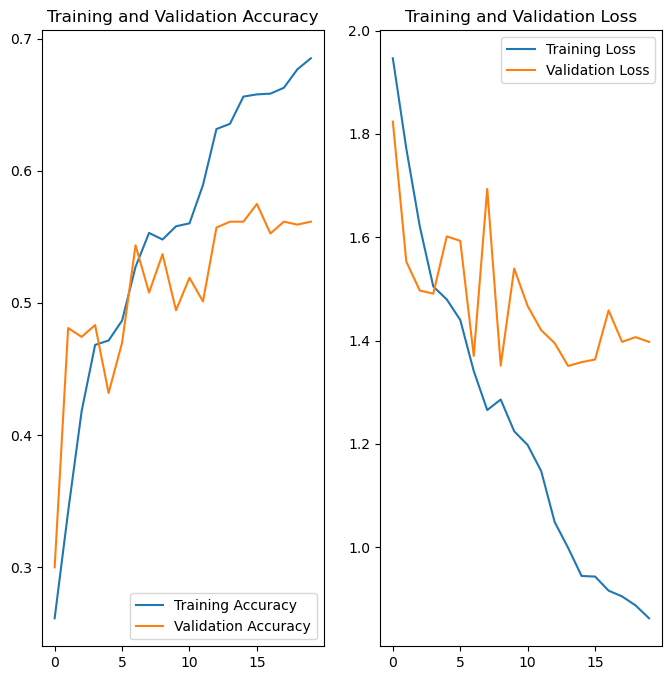

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<Figure size 3000x1000 with 0 Axes>

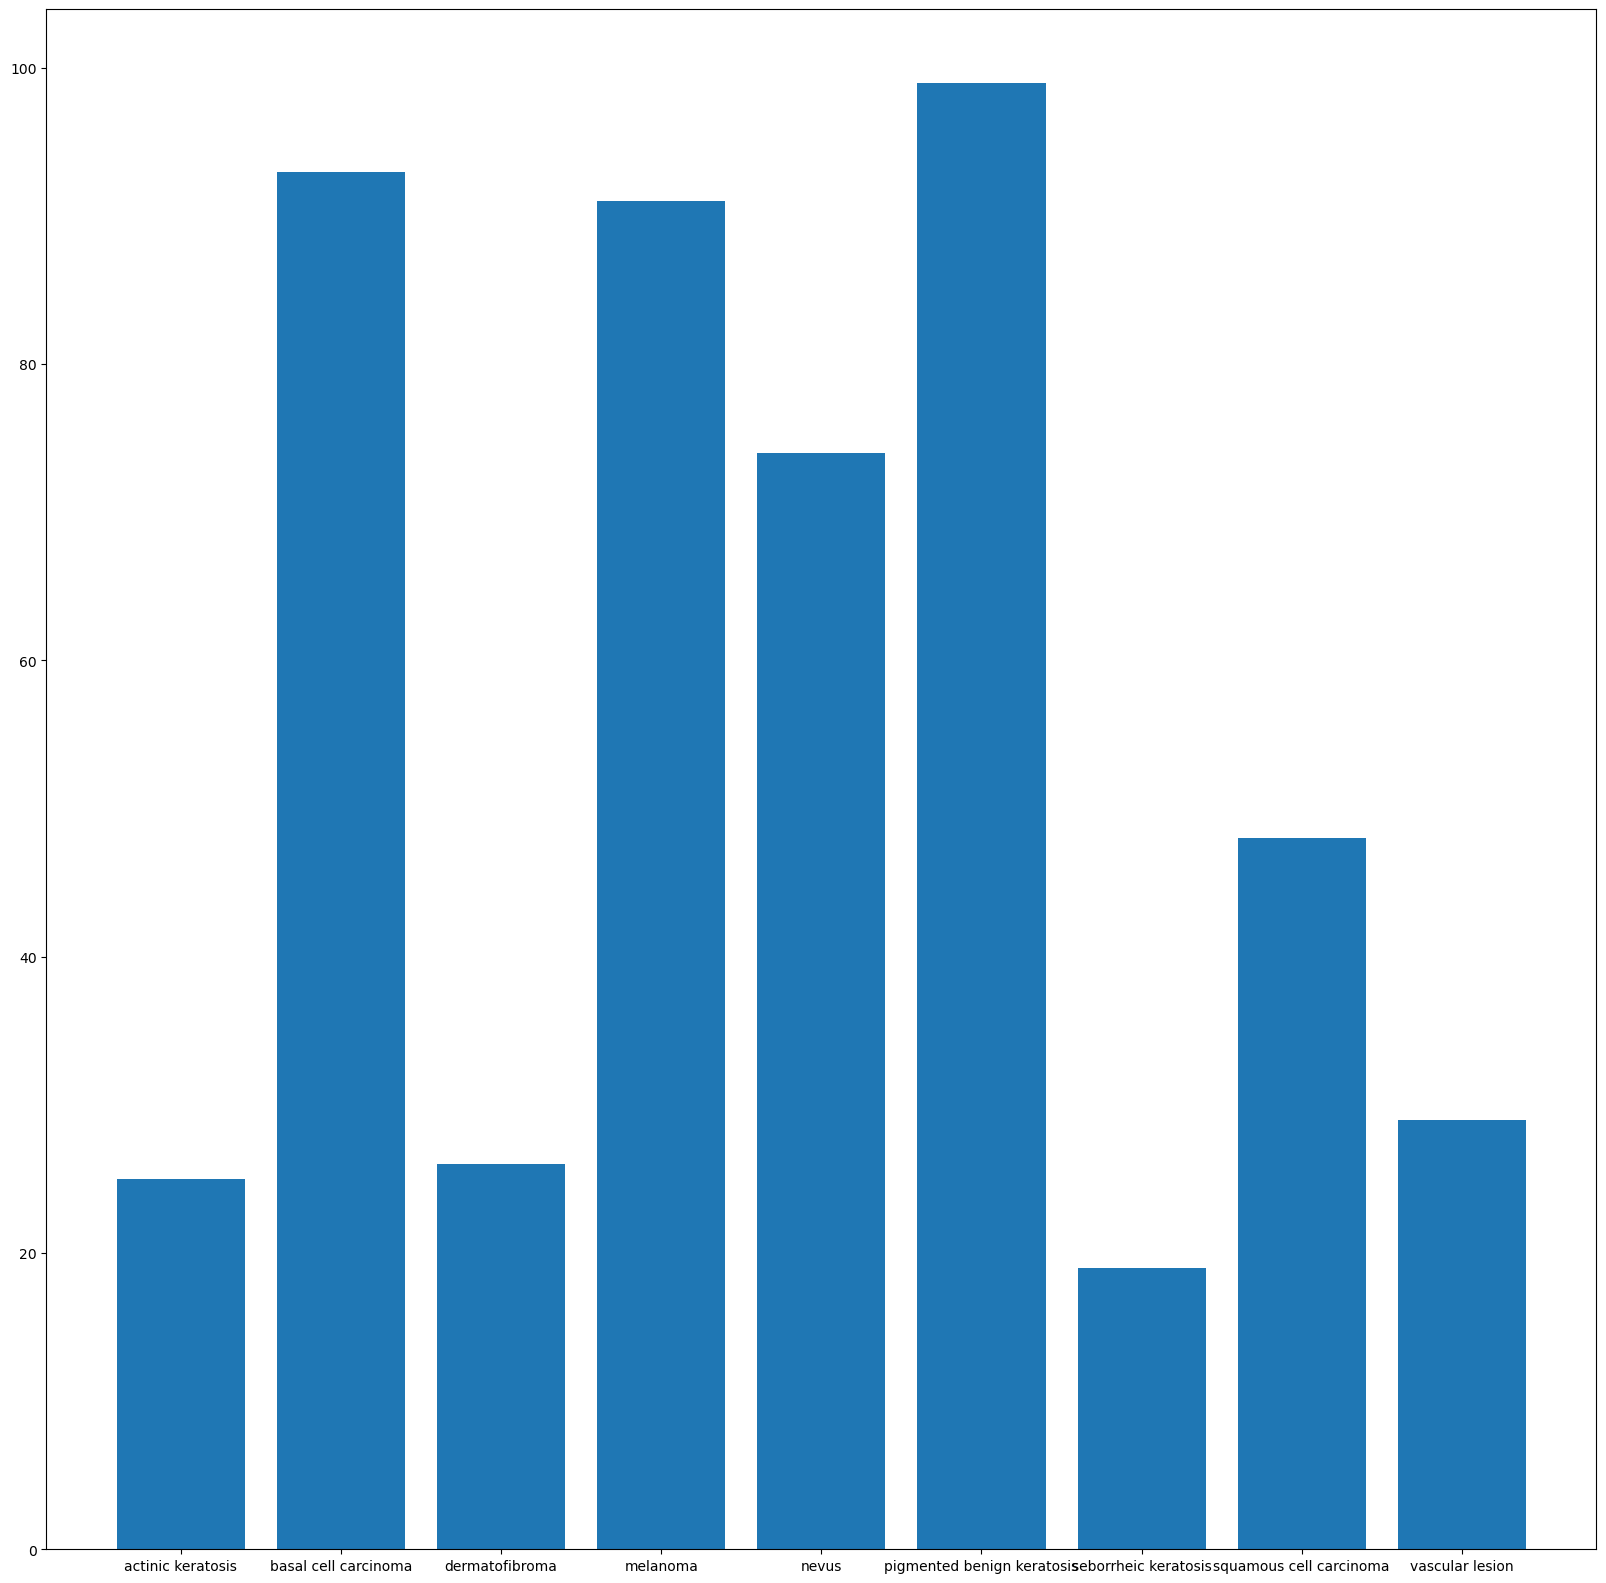

In [43]:
def plot_class_dist():
  
    data = dict()
    for i in class_names:
        data[i] = []

    plt.figure(figsize=(30, 10))
    for images, labels in train_ds:
        for i in range(9):
            data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

    for i in data:
        data[i] = len(data[i]) 

    f = plt.figure()
    f.set_figwidth(20)
    f.set_figheight(20)

    plt.bar(range(len(data)), list(data.values()), align='center')
    plt.xticks(range(len(data)), list(data.keys()))
    plt.show()

plot_class_dist()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples? --> seborrheic keratosis
#### - Which classes dominate the data in terms proportionate number of samples? --> melonoma.


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

#### !pip install Augmentor

##### Augmentor is already installed 

(base) INPUNML310892:~ ssrihar$ pip3.11 install Augmentor
Requirement already satisfied: Augmentor in /opt/homebrew/lib/python3.11/site-packages (0.2.12)
Requirement already satisfied: Pillow>=5.2.0 in /opt/homebrew/lib/python3.11/site-packages (from Augmentor) (10.1.0)
Requirement already satisfied: tqdm>=4.9.0 in /opt/homebrew/lib/python3.11/site-packages (from Augmentor) (4.66.4)
Requirement already satisfied: numpy>=1.11.0 in /opt/homebrew/lib/python3.11/site-packages (from Augmentor) (1.26.4)

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
(base) INPUNML310892:~ ssrihar$ 

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [44]:
import Augmentor
print(Augmentor.__version__)

path_to_training_dataset="cancerData/Train/"

for i in class_names:
    print(i)
    p = Augmentor.Pipeline(str(path_to_training_dataset) + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

0.2.12
actinic keratosis
Initialised with 114 image(s) found.
Output directory set to cancerData/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1944D58D0>: 100%|██████████| 500/500 [00:01<00:00, 269.81 Samples/s]                  


basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to cancerData/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1945C7DD0>: 100%|██████████| 500/500 [00:02<00:00, 223.75 Samples/s]                  


dermatofibroma
Initialised with 95 image(s) found.
Output directory set to cancerData/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1944B5F90>: 100%|██████████| 500/500 [00:01<00:00, 261.44 Samples/s]


melanoma
Initialised with 438 image(s) found.
Output directory set to cancerData/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x1948F5450>: 100%|██████████| 500/500 [00:08<00:00, 55.63 Samples/s]                  


nevus
Initialised with 357 image(s) found.
Output directory set to cancerData/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=3072x2304 at 0x194E2B150>: 100%|██████████| 500/500 [00:08<00:00, 58.35 Samples/s]


pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to cancerData/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x194515690>: 100%|██████████| 500/500 [00:02<00:00, 193.36 Samples/s]                  


seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to cancerData/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x194474E50>: 100%|██████████| 500/500 [00:04<00:00, 119.54 Samples/s]


squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to cancerData/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x19440D410>: 100%|██████████| 500/500 [00:01<00:00, 273.98 Samples/s]                  


vascular lesion
Initialised with 139 image(s) found.
Output directory set to cancerData/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x194477A50>: 100%|██████████| 500/500 [00:01<00:00, 270.45 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [45]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [46]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['cancerData/Train/melanoma/output/melanoma_original_ISIC_0000303.jpg_11b3e194-a271-4ef3-a094-762273aa9ab9.jpg',
 'cancerData/Train/melanoma/output/melanoma_original_ISIC_0010729.jpg_7246e42c-aeba-43c0-9511-4d04e48a8bb2.jpg',
 'cancerData/Train/melanoma/output/melanoma_original_ISIC_0010797.jpg_6fae8113-4cb6-41ec-b26b-d62e638513f4.jpg',
 'cancerData/Train/melanoma/output/melanoma_original_ISIC_0010478.jpg_be687906-6aff-46e0-8523-c38b228572d2.jpg',
 'cancerData/Train/melanoma/output/melanoma_original_ISIC_0000295.jpg_82efa4de-47a7-43d8-ab4d-7f5d9ba0364d.jpg',
 'cancerData/Train/melanoma/output/melanoma_original_ISIC_0010516.jpg_26678a96-cc28-4c6a-b134-3145ca250fa0.jpg',
 'cancerData/Train/melanoma/output/melanoma_original_ISIC_0010056.jpg_768197c4-4acf-4f1f-aa90-339a30552295.jpg',
 'cancerData/Train/melanoma/output/melanoma_original_ISIC_0000147.jpg_7aabd351-e558-471f-8020-36d2b08f67f9.jpg',
 'cancerData/Train/melanoma/output/melanoma_original_ISIC_0011163.jpg_8e28e041-c120-4c82-a8af-e9

In [47]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [48]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [49]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [50]:
new_df['Label'].value_counts()

Label
melanoma                      500
pigmented benign keratosis    500
nevus                         500
basal cell carcinoma          500
actinic keratosis             500
squamous cell carcinoma       500
vascular lesion               500
seborrheic keratosis          500
dermatofibroma                500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [51]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [52]:
data_dir_train= pathlib.Path("./cancerData/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [53]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [54]:
from keras.layers import BatchNormalization

In [59]:
## your code goes here

def create_new_model_old():

    input_shape = (180,180,3)
    lr = 1e-5
    init = 'normal'
    activ = 'relu'

    model = Sequential([
    layers.Rescaling(1./255,input_shape=input_shape),
    
    Conv2D(32, (3, 3), activation='relu', padding='same',input_shape=input_shape),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same',input_shape=input_shape),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same',input_shape=input_shape),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu', padding='same',input_shape=input_shape),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.25),


    Conv2D(16, (7, 7), activation='relu', padding='same',input_shape=input_shape),
    MaxPooling2D((2, 2)),
    BatchNormalization(),

    Dropout(0.25),

    Conv2D(128, (11, 11), activation='relu', padding='same', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.25),


    Conv2D(256, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.25),  

    Flatten(),
    Dense(128, activation='relu'),
    #Dropout(0.5),
    Dense(9, activation='sigmoid')
])
    
    return model,model.summary()


def create_new_model():
    model = Sequential([
    Rescaling(1./255,input_shape=(180,180,3)),
    Conv2D(32,kernel_size=(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(64,kernel_size=(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(128,kernel_size=(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Conv2D(256,kernel_size=(11,11),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    Flatten(),
    Dense(256,activation='relu'),
    Dropout(0.25),
    Dense(128,activation='relu'),
    Dropout(0.25),
    Dense(64,activation='relu'),
    Dropout(0.25),
    Dense(len(class_names),activation='sigmoid')
    ])

    return model,model.summary()

#model, model.summary = create_new_model_old()
model, model.summary = create_new_model()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_23 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 89, 89, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 43, 43, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 41, 41, 128)      

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [60]:
## your code goes here
compile_model(model, 'adam', "sparse_categorical_crossentropy", ['accuracy'])

#### **Todo:**  Train your model

In [61]:
epochs = 50
## Your code goes here, use 50 epochs.
history = train_model(model,epochs,train_ds,val_ds,control_lr_rate())

Epoch 1/50
169/169 [==============================] - 121s 707ms/step - loss: 2.1059 - accuracy: 0.1754 - val_loss: 1.9046 - val_accuracy: 0.2086 - lr: 0.0010
Epoch 2/50
169/169 [==============================] - 118s 698ms/step - loss: 1.8805 - accuracy: 0.2528 - val_loss: 1.7757 - val_accuracy: 0.3163 - lr: 0.0010
Epoch 3/50
169/169 [==============================] - 123s 728ms/step - loss: 1.7021 - accuracy: 0.3544 - val_loss: 1.4535 - val_accuracy: 0.4239 - lr: 0.0010
Epoch 4/50
169/169 [==============================] - 120s 707ms/step - loss: 1.6379 - accuracy: 0.3774 - val_loss: 1.6518 - val_accuracy: 0.3779 - lr: 0.0010
Epoch 5/50
169/169 [==============================] - 118s 693ms/step - loss: 1.5380 - accuracy: 0.3974 - val_loss: 1.4596 - val_accuracy: 0.4365 - lr: 0.0010
Epoch 6/50
169/169 [==============================] - 118s 696ms/step - loss: 1.5302 - accuracy: 0.4134 - val_loss: 1.3436 - val_accuracy: 0.4625 - lr: 0.0010
Epoch 7/50
169/169 [==========================

#### **Todo:**  Visualize the model results

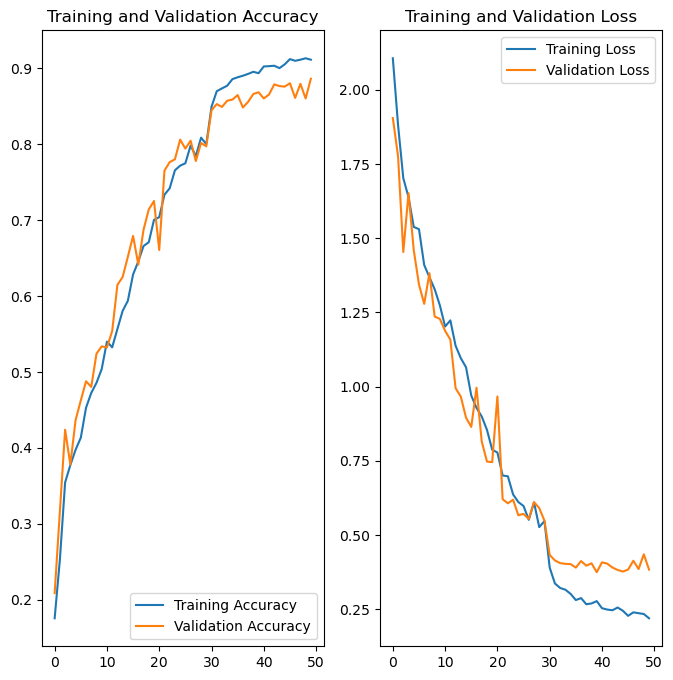

In [62]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Training vs Validation Accuracy Plotting


![Alt text](image.png)

![Alt text](model_1.png)

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



Findings

#### Model-1 with Normalization

* The training accuracy and validation accuracy are almost same for this. This is good fit.
* The training loss and validation loss are almost same. This shows positivity.
* The Validation accuracy is ~0.87 which is good. The model is able to classify the images with 87% accuracy.


#### Model-2 without Normalization 

* The training accuracy is .91% and validation accuracy ~0.89%. This is a decent fit with a delta of 2-3% ie acceptable range.
* The training loss and validation loss are almost same. This shows positivity.
* The validation accuracy is ~0.89 which is good. The model is able to classify the images with 89% accuracy.